In [1]:
import keras
keras.__version__

C:\Users\s4d-asus-14\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.2'


# Visualiser ce que les réseaux apprennent

On dit souvent que les modèles d'apprentissage en profondeur sont des "boîtes noires", des représentations d'apprentissage difficiles à extraire et à présenter de manière lisible par l'homme. Bien que cela soit partiellement vrai pour certains types de modèles d’apprentissage en profondeur, ce n’est certainement pas le cas pour les convnets. 


Les représentations apprises par les convois sont très faciles à visualiser, en grande partie parce qu’elles sont _des représentations visuelles des concepts_. 


Depuis 2013, de nombreuses techniques ont été développées pour visualiser et interpréter ces représentations. Nous ne les étudierons pas tous, mais nous couvrirons trois des plus accessibles et des plus utiles:

* Visualisation des sorties convnet intermédiaires ("activations intermédiaires")
* Visualiser les filtres convnets
* Visualisation des cartes thermiques d'activation de classe dans une image

In [5]:
%matplotlib inline

## Visualisation des activations intermédiaires

Visualiser les activations intermédiaires consiste à afficher les cartes de caractéristiques émises par différentes couches de convolution et de regroupement dans un réseau, à partir d'une entrée donnée (la sortie d'une couche s'appelle souvent son "activation", la sortie de la fonction d'activation). 


Cela donne une vue sur la manière dont une entrée est décomposée en différents filtres appris par le réseau. Ces cartes de caractéristiques que nous voulons visualiser ont 3 dimensions: largeur, hauteur et profondeur (canaux). Chaque canal code des caractéristiques relativement indépendantes. La manière appropriée de visualiser ces cartes de caractéristiques consiste à tracer indépendamment le contenu de chaque canal, sous la forme d'une image 2D.

In [37]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()  # As a reminder.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 15, 15, 128)       147584    
__________

This will be the input image we will use -- a picture of a cat, not part of images that the network was trained on:

In [38]:
img_path = './cats-dogs/train/cats/cat.1700.jpg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


Let's display our picture:

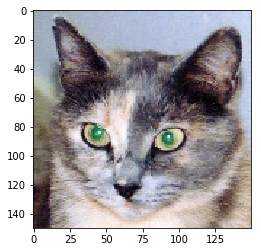

In [39]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [40]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [41]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

In [42]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


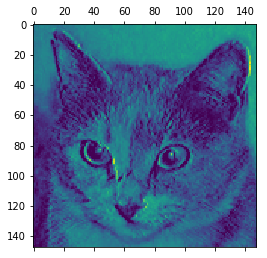

In [46]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :,2], cmap='viridis')
plt.show()

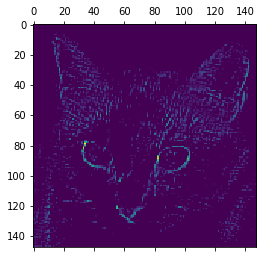

In [12]:
plt.matshow(first_layer_activation[0, :, :, 10], cmap='viridis')
plt.show()

C:\Users\s4d-asus-14\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


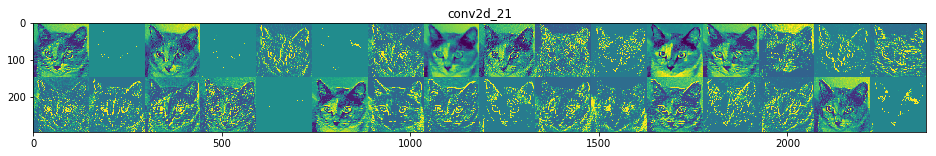

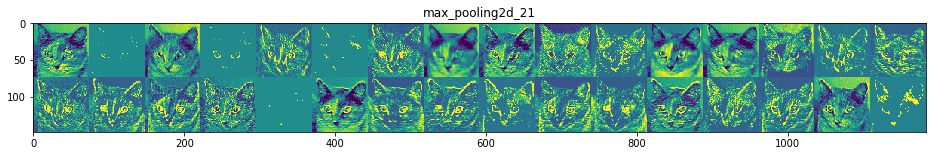

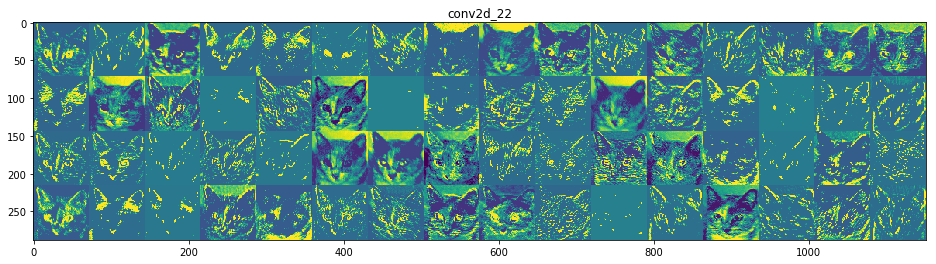

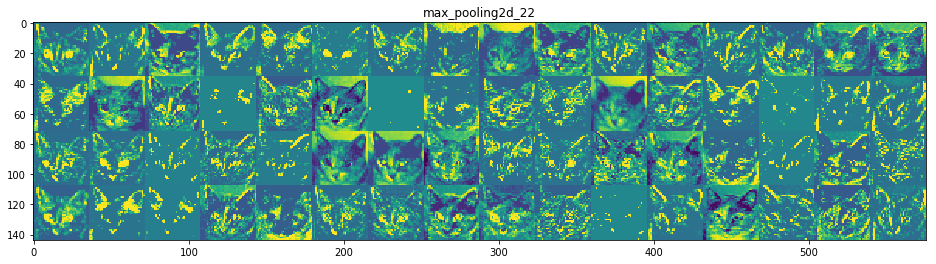

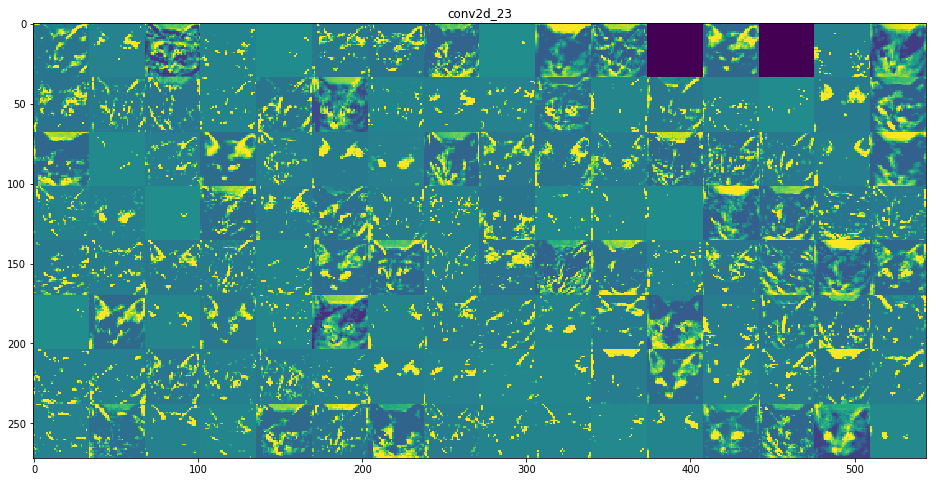

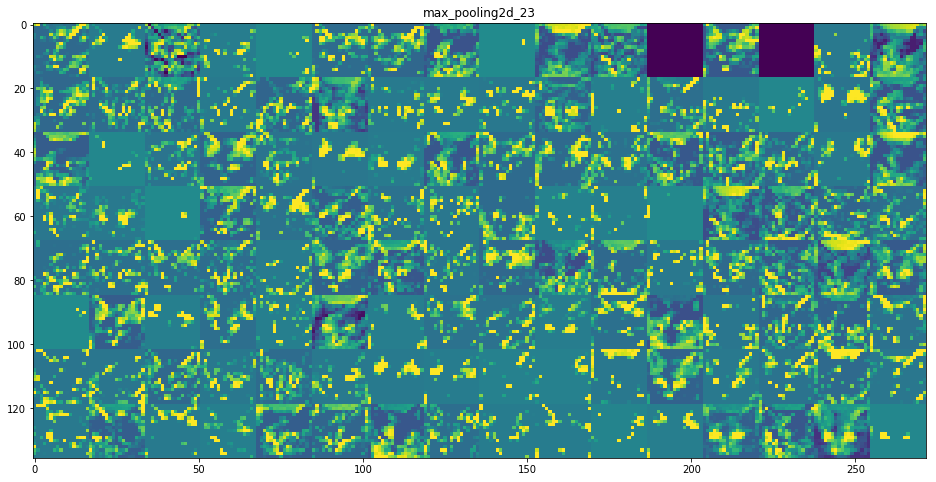

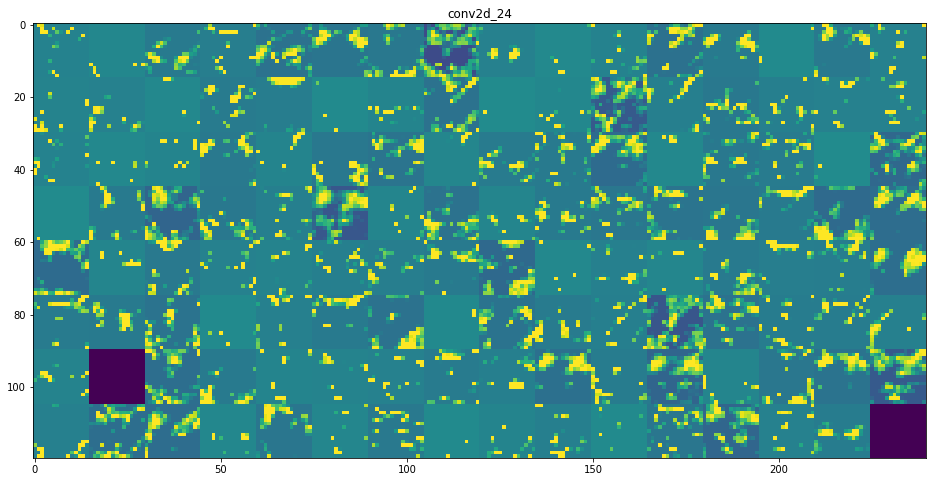

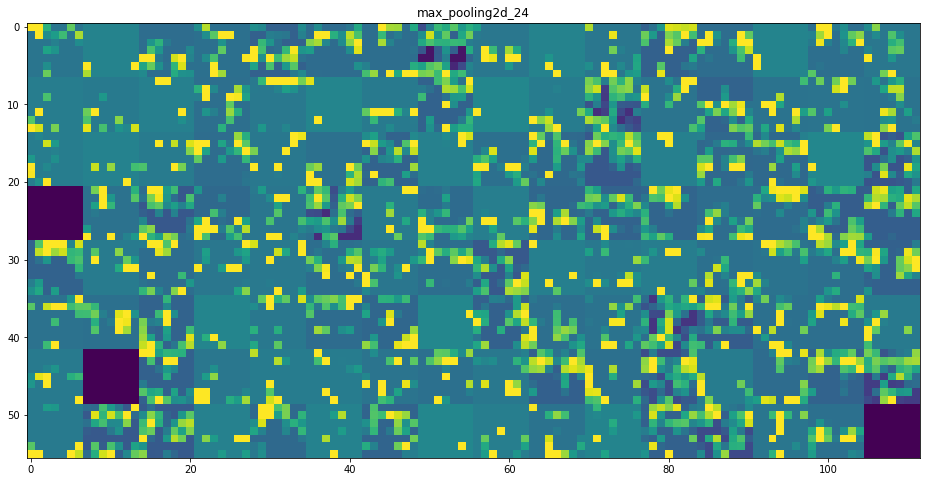

In [47]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()


Quelques points remarquables à noter ici:

* La première couche agit comme une collection de divers détecteurs de bord. A ce stade, les activations conservent encore la quasi-totalité des informations présentes dans l'image initiale.


* Au fur et à mesure que nous montons, les activations deviennent de plus en plus abstraites et de moins en moins interprétables visuellement. Ils commencent à coder des concepts de niveau supérieur tels que "oreille de chat" ou "œil de chat". Les présentations en hauteur contiennent de moins en moins d'informations sur le contenu visuel de l'image et de plus en plus d'informations relatives à la classe de l'image.


* La fréquence des activations augmente avec la profondeur du calque: dans le premier calque, tous les filtres sont activés par l'image d'entrée, mais dans les calques suivants, de plus en plus de filtres sont vides. Cela signifie que le motif encodé par le filtre est introuvable dans l'image d'entrée.


## Visualisation des cartes thermiques d'activation de classe

Nous allons présenter une autre technique de visualisation, utile pour comprendre quelles parties d’une image sont celles qui ont amené un réseau téléphonique à prendre sa décision de classification finale. Ceci est utile pour "déboguer" le processus de décision d'un convnet, en particulier en cas d'erreur de classification. Il vous permet également de localiser des objets spécifiques dans une image.

In [48]:
from keras.applications.vgg16 import VGG16

#K.clear_session()

# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')

In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Let's consider the following image of two African elephants, possible a mother and its cub, strolling in the savanna (under a Creative 
Commons license):

![elephants]( ./cats-dogs/train/cats/cat.190.jpg)

In [58]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
# The local path to our target image
img_path = './cats-dogs/train/cats/cat.190.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [59]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=4)[0])

Predicted: [('n02808304', 'bath_towel', 0.6432992), ('n02105056', 'groenendael', 0.09868597), ('n02104365', 'schipperke', 0.092015624), ('n03887697', 'paper_towel', 0.06563548)]


In [17]:
np.argmax(preds[0])

434

In [53]:
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 386]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

For visualization purpose, we will also normalize the heatmap between 0 and 1:

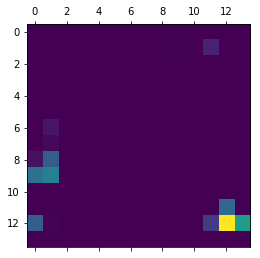

In [54]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [21]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
#cv2.save('./cats-dogs/train/cats/cat.190.jpg', 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


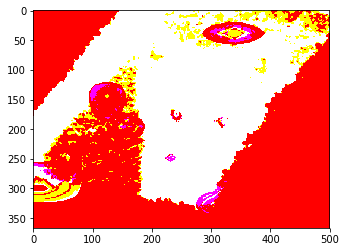

In [22]:
plt.imshow(superimposed_img.astype("int8"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


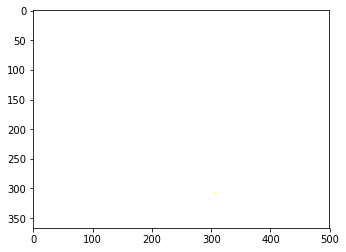

In [46]:
plt.imshow(superimposed_img)


Cette technique de visualisation répond à deux questions importantes:

* Pourquoi le réseau pense-t-il que cette image contient un éléphant d'Afrique?
* Où se trouve l'éléphant d'Afrique sur la photo?